In [27]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import os
from forex_python.converter import CurrencyRates
from datetime import datetime

In [28]:
print("Welcome to the Financial Instrument Visual Evaluator.")
print("You’ll be prompted to enter tickers, instrument types, sectors, and other data.")
print("We'll collect price and fundamental data and generate charts for evaluation.")

Welcome to the Financial Instrument Visual Evaluator.
You’ll be prompted to enter tickers, instrument types, sectors, and other data.
We'll collect price and fundamental data and generate charts for evaluation.


In [29]:
# Data Input Method Selection
input_method = input("Select input method (1 for CSV, 2 for manual entry): ").strip()

df = pd.DataFrame(columns=["Ticker", "Instrument Type", "Sector", "Region", 
                          "Allocation (%)", "Currency", "Conversion Rate (to TWD)"])

# Option 1: Load from CSV
if input_method == "1":
    csv_file = input("Enter CSV filename (default: Instrument_Allocation_Template.csv): ").strip()
    if not csv_file:
        csv_file = "Instrument_Allocation_Template.csv"
    
    # Check if the CSV file exists
    if not os.path.isfile(csv_file):
        print(f"Error: The file '{csv_file}' does not exist.")
        print("Please create this file with the following columns:")
        print("Ticker, Instrument Type, Sector, Region, Allocation (%), Currency, Conversion Rate (to TWD)")
        print("Example:")
        print("AAPL,Stock,Technology,US,20,USD,")
        print("2330.TW,Stock,Technology,Taiwan,30,TWD,")
    else:
        try:
            # Read the CSV file
            df = pd.read_csv(csv_file)
            print(f"Successfully loaded {len(df)} instruments from {csv_file}")
            
            # Validate required columns
            required_columns = ["Ticker", "Instrument Type", "Sector", "Region", 
                               "Allocation (%)", "Currency"]
            missing_columns = [col for col in required_columns if col not in df.columns]
            
            if missing_columns:
                print(f"Warning: The following required columns are missing: {missing_columns}")
                print("Please update your CSV file with the correct column headers.")
        except Exception as e:
            print(f"Error loading CSV file: {e}")

# Option 2: Manual Entry
elif input_method == "2":
    instruments = []
    print("\nEnter information for each instrument:")
    print("(Enter 'done' for ticker when finished)")
    
    while True:
        ticker = input("\nEnter ticker symbol (or type 'done' to finish): ").strip()
        if ticker.lower() == 'done':
            break
        instrument_type = input("Instrument Type (Stock, ETF, Bond, etc.): ").strip()
        sector = input("Sector (e.g., Technology, Healthcare): ").strip()
        region = input("Region (US, Europe, Asia-Pacific, etc.): ").strip()
        
        while True:
            try:
                allocation = float(input("Allocation percentage (0-100): ").strip())
                break
            except ValueError:
                print("Please enter a valid number.")
        
        currency = input("Currency (USD or TWD): ").strip().upper()

        instruments.append({
            "Ticker": ticker,
            "Instrument Type": instrument_type,
            "Sector": sector,
            "Region": region,
            "Allocation (%)": allocation,
            "Currency": currency,
            "Conversion Rate (to TWD)": None
        })

    df = pd.DataFrame(instruments)
    print(f"Successfully added {len(df)} instruments manually.")

else:
    print("Invalid selection. Please run the program again and select 1 or 2.")


Successfully loaded 8 instruments from Instrument_Allocation_Template.csv


In [30]:
# Option 1: Use a direct API call with requests
def get_exchange_rate(from_currency, to_currency):
    import requests
    try:
        # Using a free currency API (there are many alternatives)
        url = f"https://open.er-api.com/v6/latest/{from_currency}"
        response = requests.get(url)
        data = response.json()
        
        if 'rates' in data and to_currency in data['rates']:
            return data['rates'][to_currency]
        else:
            # Default fallback value if needed
            print(f"Couldn't find conversion rate for {from_currency} to {to_currency}")
            return None
    except Exception as e:
        print(f"Exchange rate API error: {e}")
        return None

# Option 2: Use hardcoded rates for common pairs if API is unreliable
def get_hardcoded_rate(from_currency, to_currency):
    # Example hardcoded rates (update with current rates as needed)
    rates = {
        "USD_TWD": 31.23,  # Update this with a recent USD to TWD rate
        "TWD_USD": 0.032,  # Update this with a recent TWD to USD rate
        # Add other currency pairs as needed
    }
    
    pair_key = f"{from_currency}_{to_currency}"
    if pair_key in rates:
        return rates[pair_key]
    else:
        print(f"No hardcoded rate for {pair_key}")
        return None

# Replace the currency conversion section in your code with:
if not df.empty:
    # First try the API method
    usd_to_twd = get_exchange_rate('USD', 'TWD')
    
    # If API failed, fall back to hardcoded rate
    if usd_to_twd is None:
        usd_to_twd = get_hardcoded_rate('USD', 'TWD')
        print(f"Using hardcoded USD to TWD rate: {usd_to_twd}")
    else:
        print(f"Successfully fetched USD to TWD rate: {usd_to_twd}")
    
    # Apply the rate to the dataframe
    if usd_to_twd is not None:
        df.loc[df['Currency'] == 'USD', 'Conversion Rate (to TWD)'] = usd_to_twd
        df.loc[df['Currency'] == 'TWD', 'Conversion Rate (to TWD)'] = 1.0
    else:
        # Last resort fallback - use 1.0 for everything
        print("Warning: Using fallback conversion rate of 1.0")
        df['Conversion Rate (to TWD)'] = df['Conversion Rate (to TWD)'].fillna(1.0)
else:
    print("No data to process. Please run the program again and add instruments.")

Successfully fetched USD to TWD rate: 30.35703


In [31]:
price_data = {}
for ticker in df['Ticker']:
    try:
        stock = yf.Ticker(ticker)
        hist_daily = stock.history(period="1y", interval="1d")
        hist_weekly = stock.history(period="5y", interval="1wk")
        price_data[ticker] = {"1y_daily": hist_daily, "5y_weekly": hist_weekly}
        print(f"Downloaded data for {ticker}")
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")


Downloaded data for AAPL
Downloaded data for MSFT
Downloaded data for TSLA
Downloaded data for 2330.TW
Downloaded data for GOOGL
Downloaded data for JPM
Downloaded data for JNJ
Downloaded data for VNQ


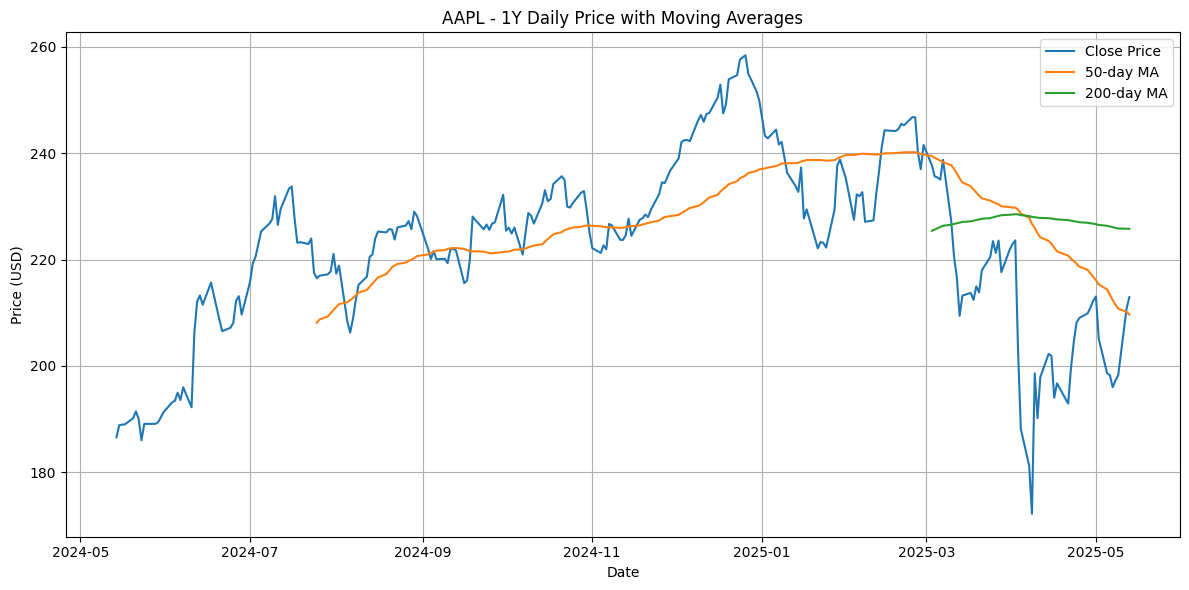

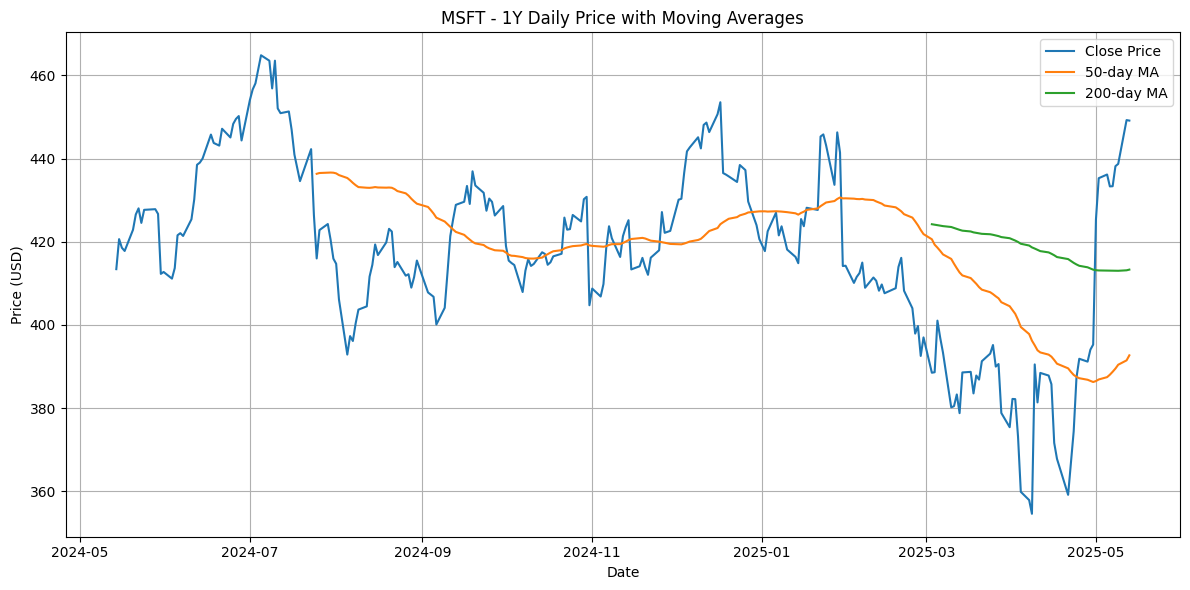

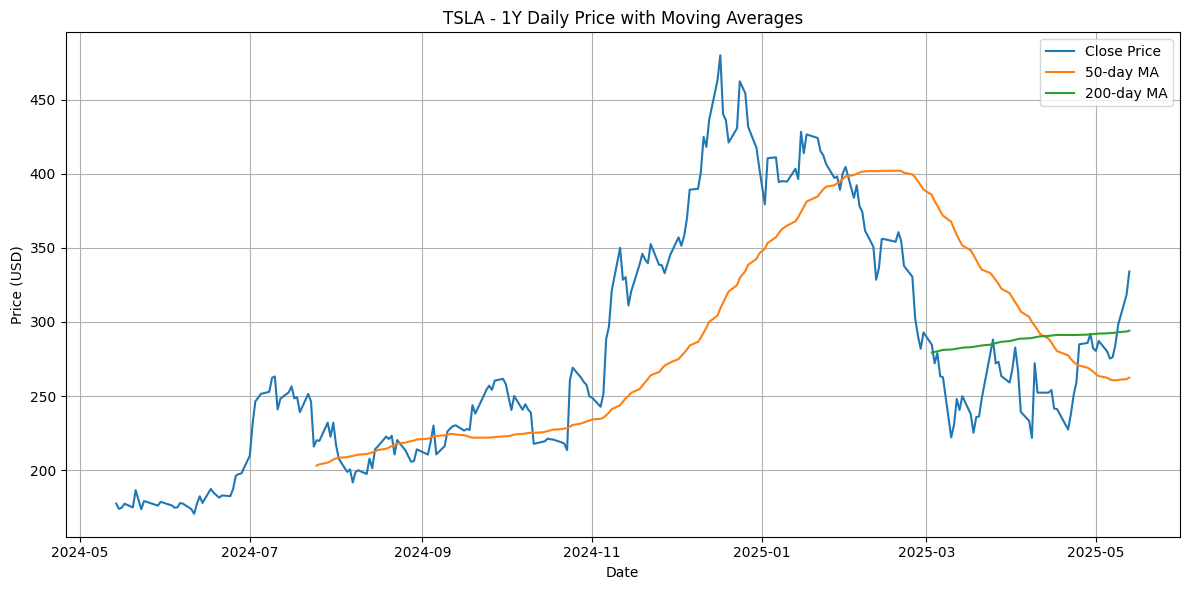

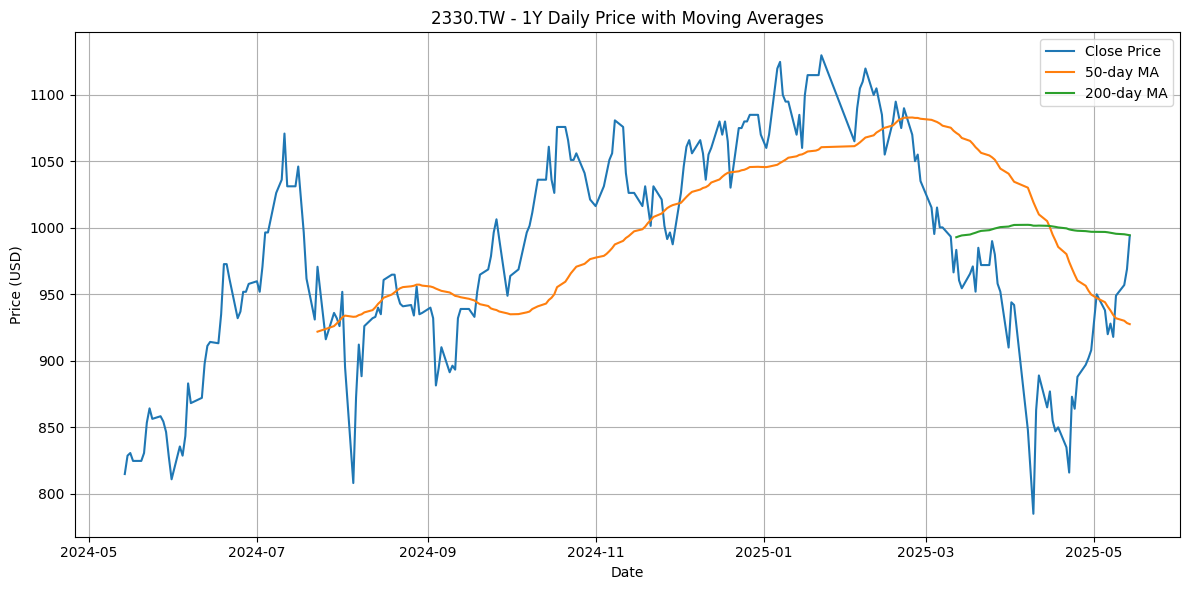

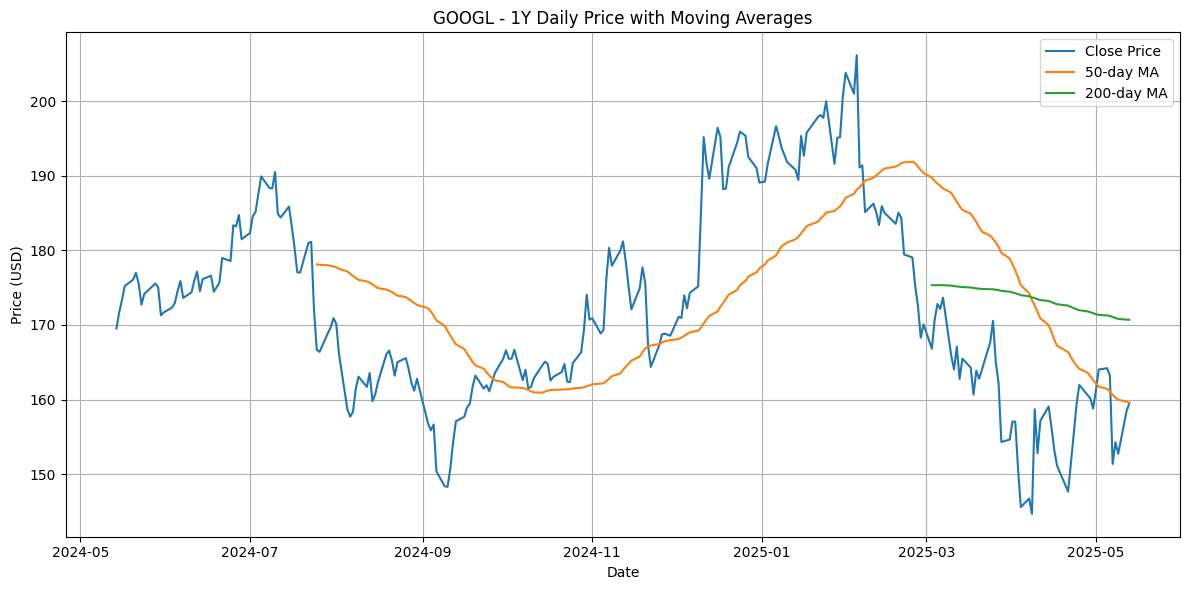

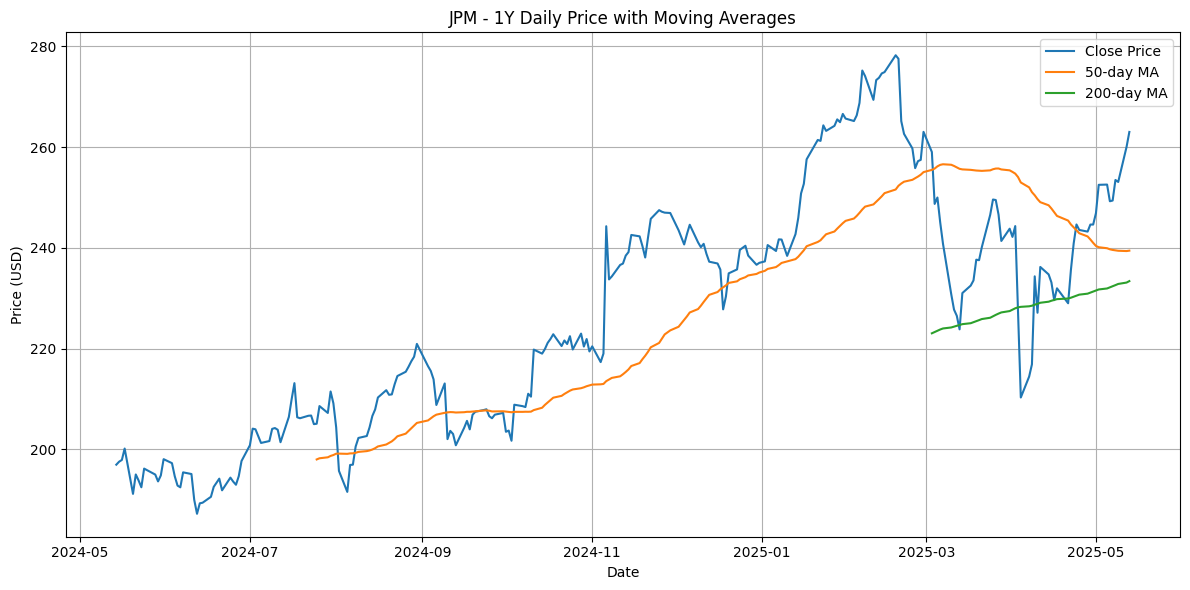

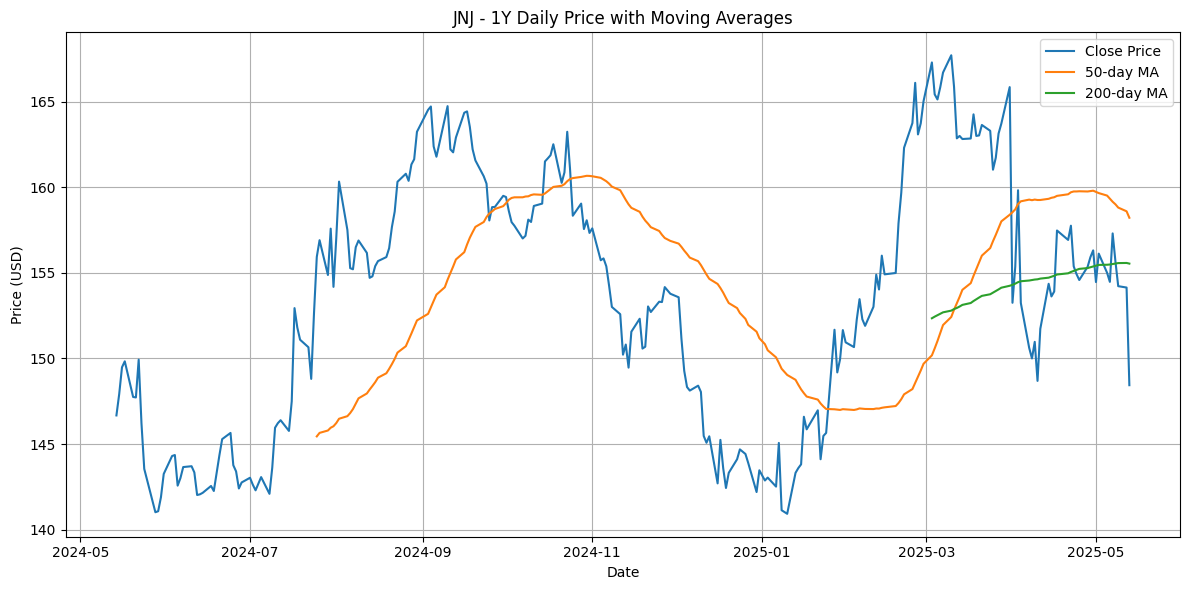

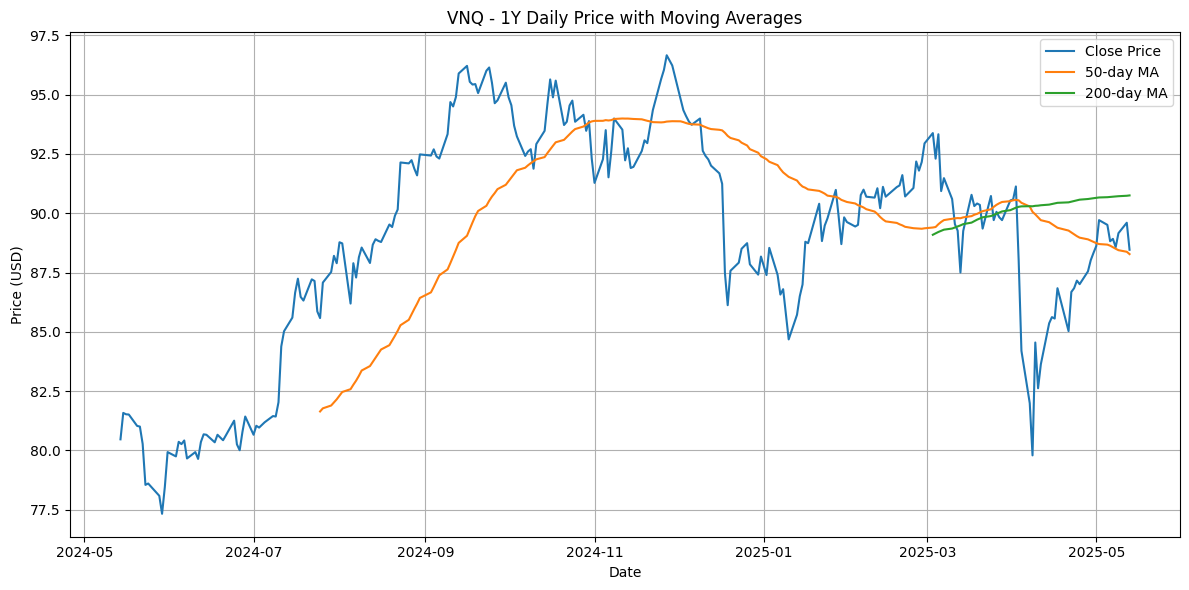

In [32]:
# Plot price + moving averages for all tickers
for ticker in df['Ticker']:
    if ticker not in price_data:
        print(f"Skipping {ticker} due to missing data.")
        continue
    
    data = price_data[ticker]['1y_daily']
    data['MA50'] = data['Close'].rolling(window=50).mean()
    data['MA200'] = data['Close'].rolling(window=200).mean()
    
    plt.figure(figsize=(12, 6))
    plt.plot(data['Close'], label='Close Price')
    plt.plot(data['MA50'], label='50-day MA')
    plt.plot(data['MA200'], label='200-day MA')
    plt.title(f"{ticker} - 1Y Daily Price with Moving Averages")
    plt.xlabel("Date")
    plt.ylabel("Price (USD)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

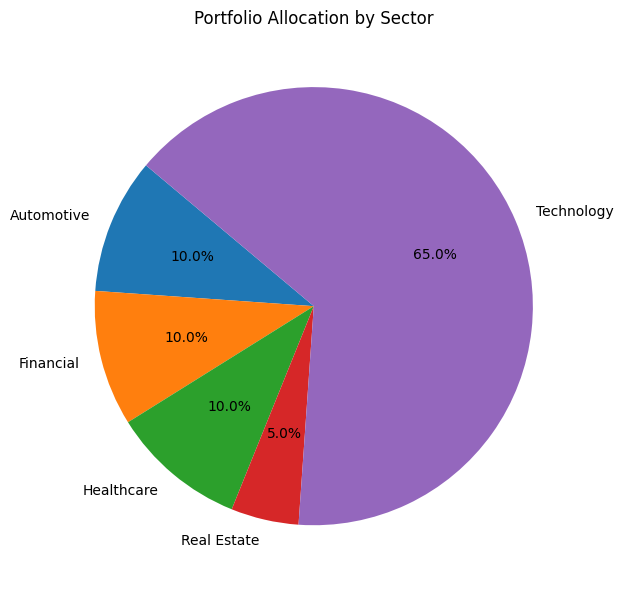

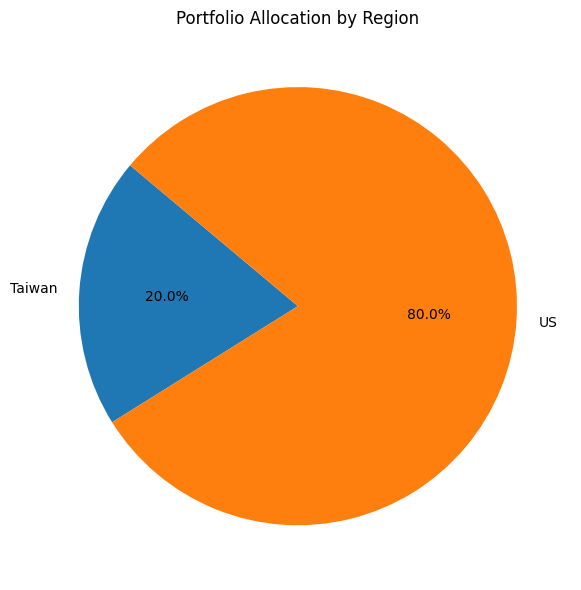

In [33]:
# name this file: sector_and_region_allocation_charts.ipynb
# Copy and paste this into a Jupyter Notebook
# Run each cell sequentially.


# Cell 9: Sector Allocation Pie Chart
plt.figure(figsize=(8, 6))
sector_data = df.groupby('Sector')['Allocation (%)'].sum()
sector_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Allocation by Sector")
plt.ylabel("")  # Hides y-label
plt.tight_layout()
plt.show()

# Cell 10: Region Allocation Pie Chart
plt.figure(figsize=(8, 6))
region_data = df.groupby('Region')['Allocation (%)'].sum()
region_data.plot(kind='pie', autopct='%1.1f%%', startangle=140)
plt.title("Portfolio Allocation by Region")
plt.ylabel("")  # Hides y-label
plt.tight_layout()
plt.show()


In [34]:
# Copy and paste this into Jupyter Notebook entitled: financial_visual_analysis.ipynb
# Run each cell sequentially.
# When you reach the plotting section, you’ll see a chart for 
# your first entered ticker.

# Cell 11: Build Return DataFrame for Correlation and Risk Analysis
returns_df = pd.DataFrame()

for ticker in df['Ticker']:
    try:
        daily_prices = price_data[ticker]['1y_daily']['Close']
        returns = daily_prices.pct_change().dropna()
        returns_df[ticker] = returns
    except KeyError:
        print(f"Missing data for {ticker}")



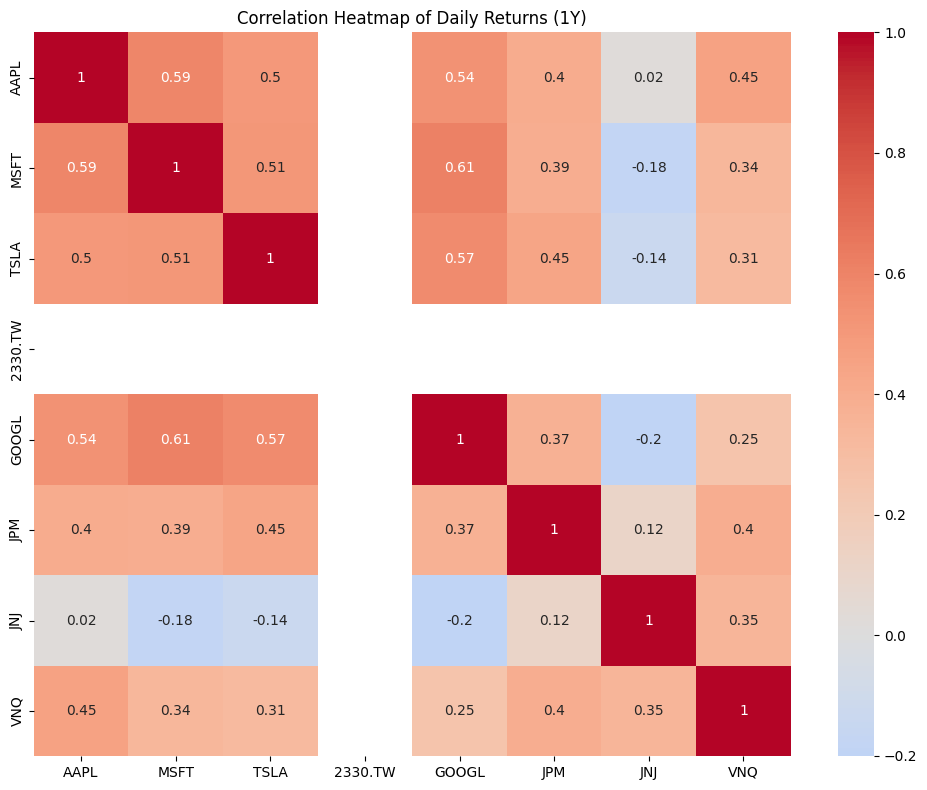

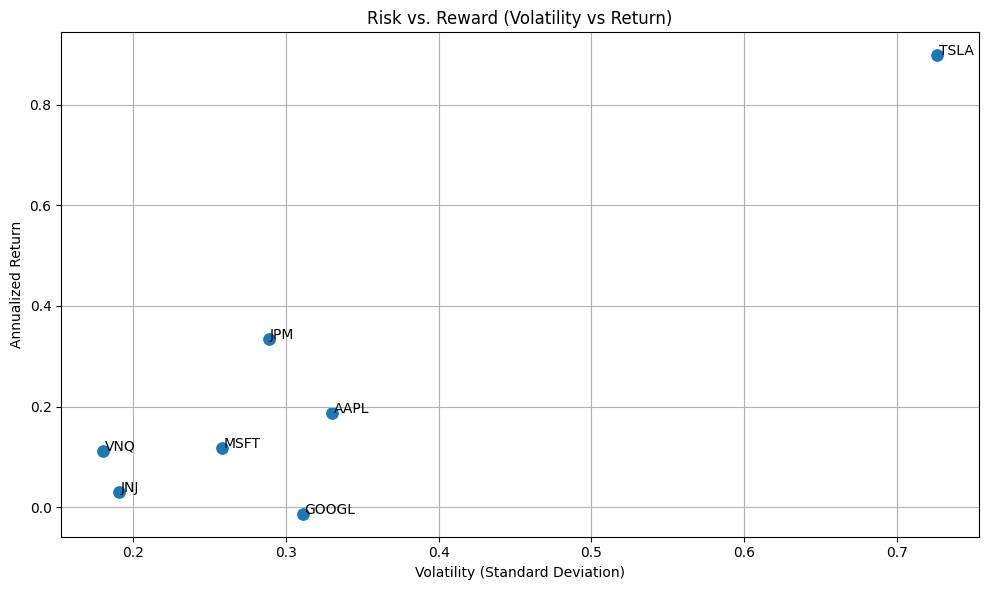

In [35]:
# Cell 12: Correlation Heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = returns_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Daily Returns (1Y)")
plt.tight_layout()
plt.show()

# Cell 13: Risk vs. Reward Scatter Plot
annualized_return = returns_df.mean() * 252  # 252 trading days
annualized_volatility = returns_df.std() * (252 ** 0.5)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=annualized_volatility, y=annualized_return, s=100)

for ticker in returns_df.columns:
    plt.text(annualized_volatility[ticker] + 0.001, annualized_return[ticker], ticker)

plt.xlabel("Volatility (Standard Deviation)")
plt.ylabel("Annualized Return")
plt.title("Risk vs. Reward (Volatility vs Return)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [36]:
# Performance Metrics Calculator
import pandas as pd
import numpy as np
from datetime import datetime
import yfinance as yf

In [37]:
# 1. TIME-WEIGHTED RETURN CALCULATOR
def calculate_time_weighted_return(portfolio_data):
    """
    Calculate time-weighted return for a portfolio
    portfolio_data: DataFrame with Date, Portfolio_Value columns
    """
    portfolio_data = portfolio_data.sort_values('Date')
    portfolio_data['Daily_Return'] = portfolio_data['Portfolio_Value'].pct_change()
    portfolio_data['Cumulative_Return'] = (1 + portfolio_data['Daily_Return']).cumprod() - 1
    total_return = portfolio_data['Cumulative_Return'].iloc[-1]
    return total_return


In [38]:
# 2. COMPOUND ANNUAL GROWTH RATE (CAGR)
def calculate_cagr(start_value, end_value, num_years):
    """
    Calculate CAGR given start value, end value, and time period
    """
    cagr = (end_value / start_value) ** (1/num_years) - 1
    return cagr


In [39]:
# 3. ROLLING PERFORMANCE CALCULATOR
def calculate_rolling_performance(portfolio_data, window_days):
    """
    Calculate rolling performance for specified window
    """
    portfolio_data = portfolio_data.sort_values('Date')
    portfolio_data['Rolling_Return'] = portfolio_data['Portfolio_Value'].pct_change(periods=window_days)
    return portfolio_data

# 4. IMPLEMENTATION EXAMPLE
# Create sample portfolio data structure
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
sample_portfolio = pd.DataFrame({
    'Date': dates,
    'Portfolio_Value': np.random.normal(50000, 1000, len(dates)).cumsum() + 50000
})

# Calculate metrics
twr = calculate_time_weighted_return(sample_portfolio)
years = (sample_portfolio['Date'].max() - sample_portfolio['Date'].min()).days / 365.25
cagr = calculate_cagr(sample_portfolio['Portfolio_Value'].iloc[0], 
                      sample_portfolio['Portfolio_Value'].iloc[-1], 
                      years)

print(f"Time-Weighted Return: {twr:.4f}")
print(f"CAGR: {cagr:.4f}")


Time-Weighted Return: 183.6486
CAGR: 184.3097


In [40]:
# Risk Assessment Calculator
import pandas as pd
import numpy as np
from scipy import stats


In [41]:
# 1. BETA CALCULATION
def calculate_beta(portfolio_returns, benchmark_returns):
    """
    Calculate beta (systematic risk) relative to benchmark
    """
    # Align the data
    aligned_data = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
    portfolio_returns = aligned_data.iloc[:, 0]
    benchmark_returns = aligned_data.iloc[:, 1]
    
    # Calculate covariance and variance
    covariance = np.cov(portfolio_returns, benchmark_returns)[0, 1]
    benchmark_variance = np.var(benchmark_returns)
    
    beta = covariance / benchmark_variance
    return beta


In [42]:
# 2. VALUE AT RISK (VaR) - HISTORICAL METHOD
def calculate_var(returns, confidence_level=0.05):
    """
    Calculate Value at Risk using historical method
    confidence_level: 0.05 for 95% VaR, 0.01 for 99% VaR
    """
    sorted_returns = np.sort(returns)
    index = int(confidence_level * len(sorted_returns))
    var = abs(sorted_returns[index])
    return var


In [43]:
# 3. SHARPE RATIO
def calculate_sharpe_ratio(portfolio_returns, risk_free_rate=0.02):
    """
    Calculate Sharpe ratio (risk-adjusted return)
    risk_free_rate: annual risk-free rate (default 2%)
    """
    # Convert annual risk-free rate to daily
    daily_rf = risk_free_rate / 252
    
    # Calculate excess returns
    excess_returns = portfolio_returns - daily_rf
    
    # Calculate Sharpe ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    return sharpe_ratio


In [44]:
# 4. MAXIMUM DRAWDOWN
def calculate_max_drawdown(portfolio_values):
    """
    Calculate maximum drawdown from peak to trough
    """
    # Calculate cumulative maximum
    running_max = np.maximum.accumulate(portfolio_values)
    
    # Calculate drawdown from peak
    drawdown = (portfolio_values - running_max) / running_max
    
    # Find maximum drawdown
    max_drawdown = np.min(drawdown)
    return abs(max_drawdown)


In [45]:
# 5. VOLATILITY CALCULATION
def calculate_volatility(returns, annualize=True):
    """
    Calculate volatility (standard deviation of returns)
    """
    volatility = np.std(returns)
    if annualize:
        volatility = volatility * np.sqrt(252)  # Annualize daily volatility
    return volatility


In [46]:
# 6. IMPLEMENTATION EXAMPLE
# Sample data generation
dates = pd.date_range(start='2024-01-01', end='2024-12-31', freq='D')
portfolio_returns = pd.Series(np.random.normal(0.0005, 0.01, len(dates)), index=dates)
benchmark_returns = pd.Series(np.random.normal(0.0004, 0.008, len(dates)), index=dates)

# Calculate risk metrics
beta = calculate_beta(portfolio_returns, benchmark_returns)
var_95 = calculate_var(portfolio_returns, 0.05)
sharpe = calculate_sharpe_ratio(portfolio_returns)
volatility = calculate_volatility(portfolio_returns)

print(f"Beta: {beta:.4f}")
print(f"95% VaR: {var_95:.4f}")
print(f"Sharpe Ratio: {sharpe:.4f}")
print(f"Annualized Volatility: {volatility:.4f}")


Beta: -0.0644
95% VaR: 0.0149
Sharpe Ratio: 1.5401
Annualized Volatility: 0.1560


In [47]:
# Benchmark Comparison and Visualization Tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf


In [48]:
# 1. BENCHMARK DATA RETRIEVAL
def get_benchmark_data(ticker, start_date, end_date):
    """
    Retrieve benchmark data from Yahoo Finance
    Common benchmarks: '^GSPC' (S&P 500), '^DJI' (Dow), '^IXIC' (NASDAQ)
    """
    benchmark = yf.download(ticker, start=start_date, end=end_date)
    benchmark['Returns'] = benchmark['Adj Close'].pct_change()
    return benchmark


In [49]:
# 2. RELATIVE PERFORMANCE CALCULATION
def calculate_relative_performance(portfolio_returns, benchmark_returns):
    """
    Calculate relative performance metrics
    """
    # Align dates
    aligned_data = pd.concat([portfolio_returns, benchmark_returns], axis=1).dropna()
    portfolio_returns = aligned_data.iloc[:, 0]
    benchmark_returns = aligned_data.iloc[:, 1]
    
    # Calculate excess returns
    excess_returns = portfolio_returns - benchmark_returns
    
    # Calculate tracking error
    tracking_error = np.std(excess_returns) * np.sqrt(252)
    
    # Calculate information ratio
    information_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    
    return {
        'excess_returns': excess_returns,
        'tracking_error': tracking_error,
        'information_ratio': information_ratio
    }


In [50]:
# 3. CUMULATIVE PERFORMANCE COMPARISON
def create_cumulative_performance_chart(portfolio_values, benchmark_values):
    """
    Create cumulative performance comparison chart
    """
    # Normalize to same starting value
    portfolio_normalized = portfolio_values / portfolio_values.iloc[0]
    benchmark_normalized = benchmark_values / benchmark_values.iloc[0]
    
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_normalized.index, portfolio_normalized.values, 
             label='Portfolio', linewidth=2, color='blue')
    plt.plot(benchmark_normalized.index, benchmark_normalized.values, 
             label='Benchmark', linewidth=2, color='red')
    
    plt.title('Cumulative Performance Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Normalized Value', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt


In [51]:
# 4. ROLLING PERFORMANCE COMPARISON
def create_rolling_performance_chart(portfolio_returns, benchmark_returns, window=30):
    """
    Create rolling performance comparison chart
    """
    # Calculate rolling returns
    portfolio_rolling = portfolio_returns.rolling(window=window).apply(
        lambda x: (1 + x).prod() - 1) * 100
    benchmark_rolling = benchmark_returns.rolling(window=window).apply(
        lambda x: (1 + x).prod() - 1) * 100
    
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_rolling.index, portfolio_rolling.values, 
             label=f'Portfolio ({window}-day)', linewidth=2, color='blue')
    plt.plot(benchmark_rolling.index, benchmark_rolling.values, 
             label=f'Benchmark ({window}-day)', linewidth=2, color='red')
    
    plt.title(f'{window}-Day Rolling Returns Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Rolling Return (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.tight_layout()
    return plt


In [52]:
# 5. RISK-RETURN SCATTER PLOT
def create_risk_return_scatter(portfolio_data, benchmark_data):
    """
    Create risk vs return scatter plot
    """
    # Calculate annual returns and volatility
    portfolio_return = portfolio_data['Returns'].mean() * 252
    portfolio_vol = portfolio_data['Returns'].std() * np.sqrt(252)
    benchmark_return = benchmark_data['Returns'].mean() * 252
    benchmark_vol = benchmark_data['Returns'].std() * np.sqrt(252)
    
    plt.figure(figsize=(10, 8))
    plt.scatter([portfolio_vol], [portfolio_return], 
                s=100, color='blue', label='Portfolio', alpha=0.7)
    plt.scatter([benchmark_vol], [benchmark_return], 
                s=100, color='red', label='Benchmark', alpha=0.7)
    
    plt.title('Risk vs Return Analysis', fontsize=16, fontweight='bold')
    plt.xlabel('Annual Volatility', fontsize=12)
    plt.ylabel('Annual Return', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt


In [53]:
# 6. DRAWDOWN COMPARISON
def create_drawdown_comparison(portfolio_values, benchmark_values):
    """
    Create drawdown comparison chart
    """
    # Calculate drawdowns
    portfolio_dd = (portfolio_values / portfolio_values.cummax() - 1) * 100
    benchmark_dd = (benchmark_values / benchmark_values.cummax() - 1) * 100
    
    plt.figure(figsize=(12, 8))
    plt.plot(portfolio_dd.index, portfolio_dd.values, 
             label='Portfolio Drawdown', linewidth=2, color='blue')
    plt.plot(benchmark_dd.index, benchmark_dd.values, 
             label='Benchmark Drawdown', linewidth=2, color='red')
    
    plt.title('Drawdown Comparison', fontsize=16, fontweight='bold')
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Drawdown (%)', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.fill_between(portfolio_dd.index, portfolio_dd.values, 0, 
                     alpha=0.3, color='blue')
    plt.fill_between(benchmark_dd.index, benchmark_dd.values, 0, 
                     alpha=0.3, color='red')
    plt.tight_layout()
    return plt


In [54]:
# 7. PERFORMANCE ATTRIBUTION ANALYSIS
def create_attribution_chart(sectors, sector_weights, sector_returns):
    """
    Create performance attribution chart by sector
    """
    attribution = sector_weights * sector_returns
    
    plt.figure(figsize=(10, 8))
    colors = plt.cm.Set3(np.linspace(0, 1, len(sectors)))
    bars = plt.bar(sectors, attribution, color=colors)
    
    plt.title('Performance Attribution by Sector', fontsize=16, fontweight='bold')
    plt.xlabel('Sector', fontsize=12)
    plt.ylabel('Contribution to Return (%)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(True, axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    return plt


In [55]:
#